In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import pickle
import plotly.graph_objs as pg
import plotly
import plotly.plotly as py
from scipy import stats
import plotly.graph_objs as go
from pandas import Series
from matplotlib import pyplot
from pandas import Series
from pandas import DataFrame
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.offline import plot_mpl
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_pickle('USJH.pkl')

In [3]:
df.shape

(83509, 37)

#### Calculate revenue

In [4]:
# fill na Discount amount na meaning it's 0
df['discount_amount'].fillna(0, inplace=True)
# fill na Refunded Amount na meaning it's 0
df['refunded_amount'].fillna(0, inplace=True)
# fill na Subtotal na meaning it's 0
df['subtotal'].fillna(0, inplace=True)
# fill na line item quantity na meaning it's 0
df['lineitem_quantity'].fillna(0, inplace=True)

# calculate revenue
df['revenue'] = df["subtotal"] - df["refunded_amount"]

# calculate weighted revenue
# df['revenue'] = df['revenue']/df['lineitem_quantity']

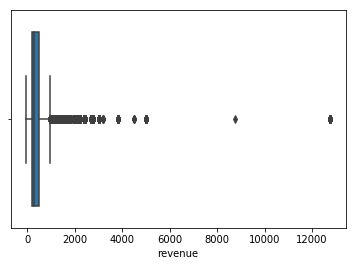

In [5]:
sns.boxplot(x=df['revenue'])

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



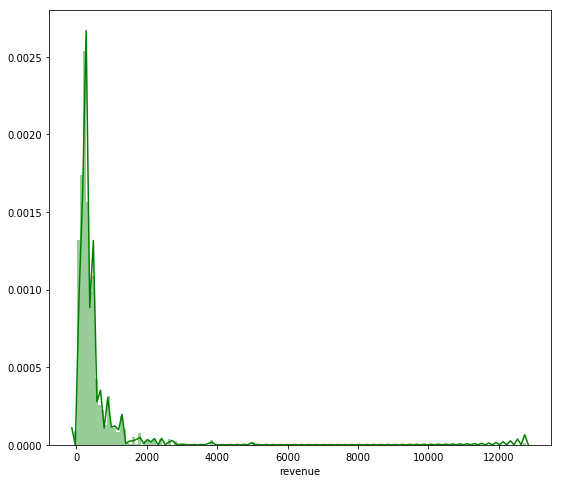

In [6]:
plt.figure(figsize=(9, 8))
sns.distplot(df['revenue'], color='g', bins=150, hist_kws={'alpha': 0.4});

In [7]:
df['revenue'].skew()

9.187260294031768

In [8]:
# before removing outliers there's 0 missing/na value
df['revenue'].isnull().sum()

0

In [9]:
# remove outliers
rm_o = df[['revenue']]
df['revenue_1'] = rm_o.loc[rm_o.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

In [10]:
df['revenue_1'].skew()

2.161711023482793

In [11]:
# removed 1415 outliers
df['revenue_1'].isnull().sum()
# df['revenue_1'].isnull().sum()/83509*100
# 1.6% outliers are being removed

1416

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning:

invalid value encountered in greater_equal

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning:

invalid value encountered in less_equal

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning:

invalid value encountered in greater

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning:

invalid value encountered in less



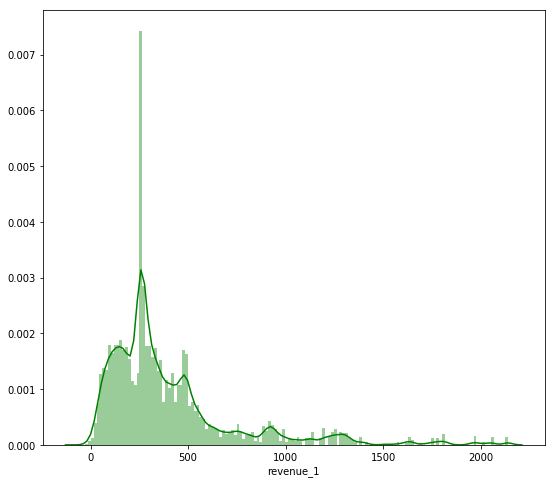

In [12]:
plt.figure(figsize=(9, 8))
sns.distplot(df['revenue_1'], color='g', bins=150, hist_kws={'alpha': 0.4});

## Identify if there's seasonality

#### Create different format of datetime columns

In [41]:
# convert created at to datetime 
df['created_at'] = pd.to_datetime(df['created_at'])
# create new column contains only year
df['year'] = df['created_at'].dt.year
# create new column contains only month
df['month'] = df['created_at'].dt.month
# create new column contains only day
df['day'] = df['created_at'].dt.day
# create new column contains only hour
df['time'] = pd.to_datetime(df['created_at'], format='%m/%d/%y %H:%M').dt.hour
# create new column contains day of week
df['day_of_week'] = df['created_at'].dt.weekday_name
# create new column contains date which doesn't have time stamp
df['date'] = df['created_at'].apply(lambda x: x.strftime("%m/%d/%y"))
df['date'] = pd.to_datetime(df['created_at'], format='%m/%d/%y')
# create new column contains month and year
df['year_month'] = pd.to_datetime(df['created_at'], format='%m/%d/%y').dt.to_period('M')
df.set_index('date', inplace= True)

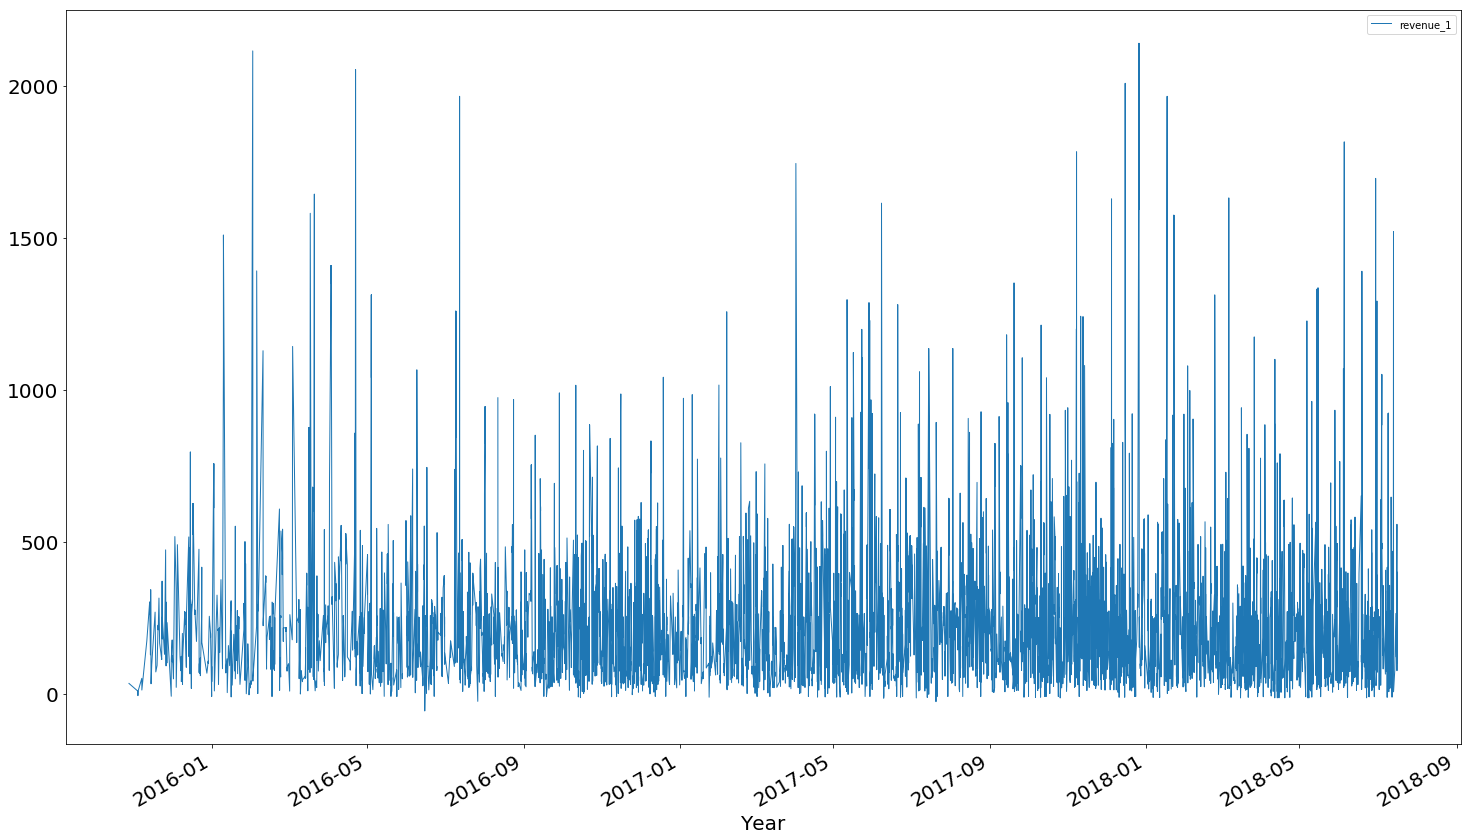

In [14]:
df[['revenue_1']].plot(figsize=(25,15), linewidth=1, fontsize=20)
plt.xlabel('Year', fontsize=20);

## Compute 12 Month Moving (Rolling) Averages of Sales

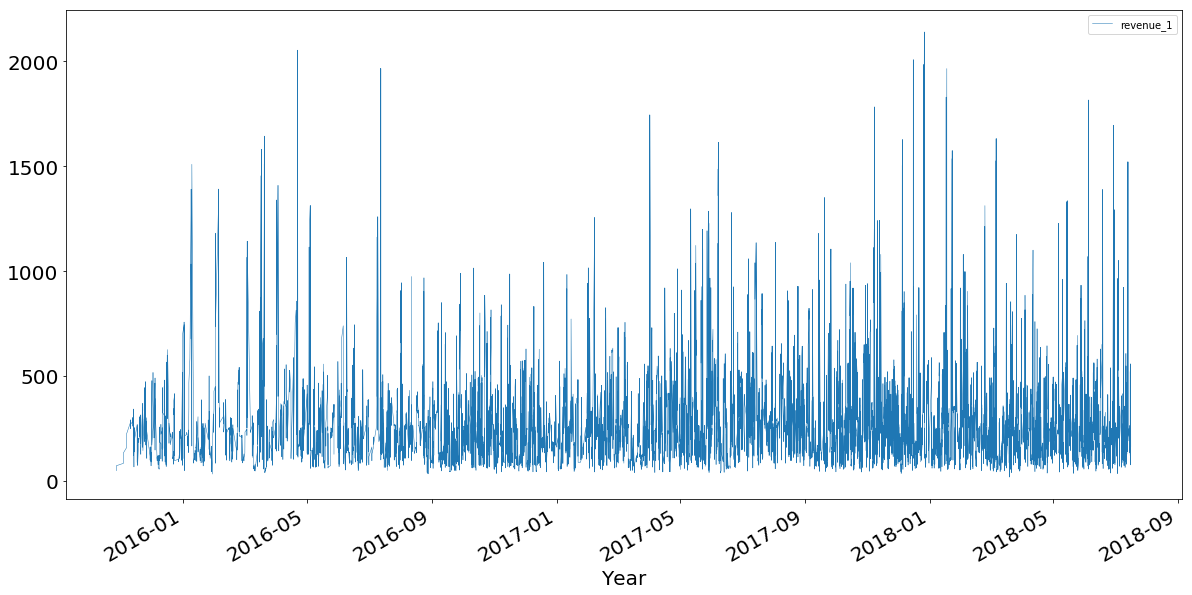

In [15]:
Revenue = df[['revenue_1']]
Revenue.rolling(12).mean().plot(figsize=(20,10), linewidth=0.5, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [16]:
# create new dataframe to see quarterly revenue
tsa_q = df.groupby(['date'])['revenue_1','subtotal','lineitem_quantity','total','discount_amount','refunded_amount'].sum()
tsa_Q_df = tsa_q.resample('Q').sum()
tsa_Q_df.reset_index(inplace= True)
tsa_Q_df['year_month'] = tsa_Q_df['date'].apply(lambda x: x.strftime("%m/%d/%y"))
tsa_Q_df['year_month'] = pd.to_datetime(tsa_Q_df['date'], format='%m/%d/%y')
# tsa_df['year_month'] = pd.to_datetime(tsa_df['date'], format='%m/%d/%y').dt.to_period('M')
tsa_Q_df.set_index('year_month', inplace= True)
tsa_Q_df['date']

year_month
2015-12-31   2015-12-31
2016-03-31   2016-03-31
2016-06-30   2016-06-30
2016-09-30   2016-09-30
2016-12-31   2016-12-31
2017-03-31   2017-03-31
2017-06-30   2017-06-30
2017-09-30   2017-09-30
2017-12-31   2017-12-31
2018-03-31   2018-03-31
2018-06-30   2018-06-30
2018-09-30   2018-09-30
Name: date, dtype: datetime64[ns]

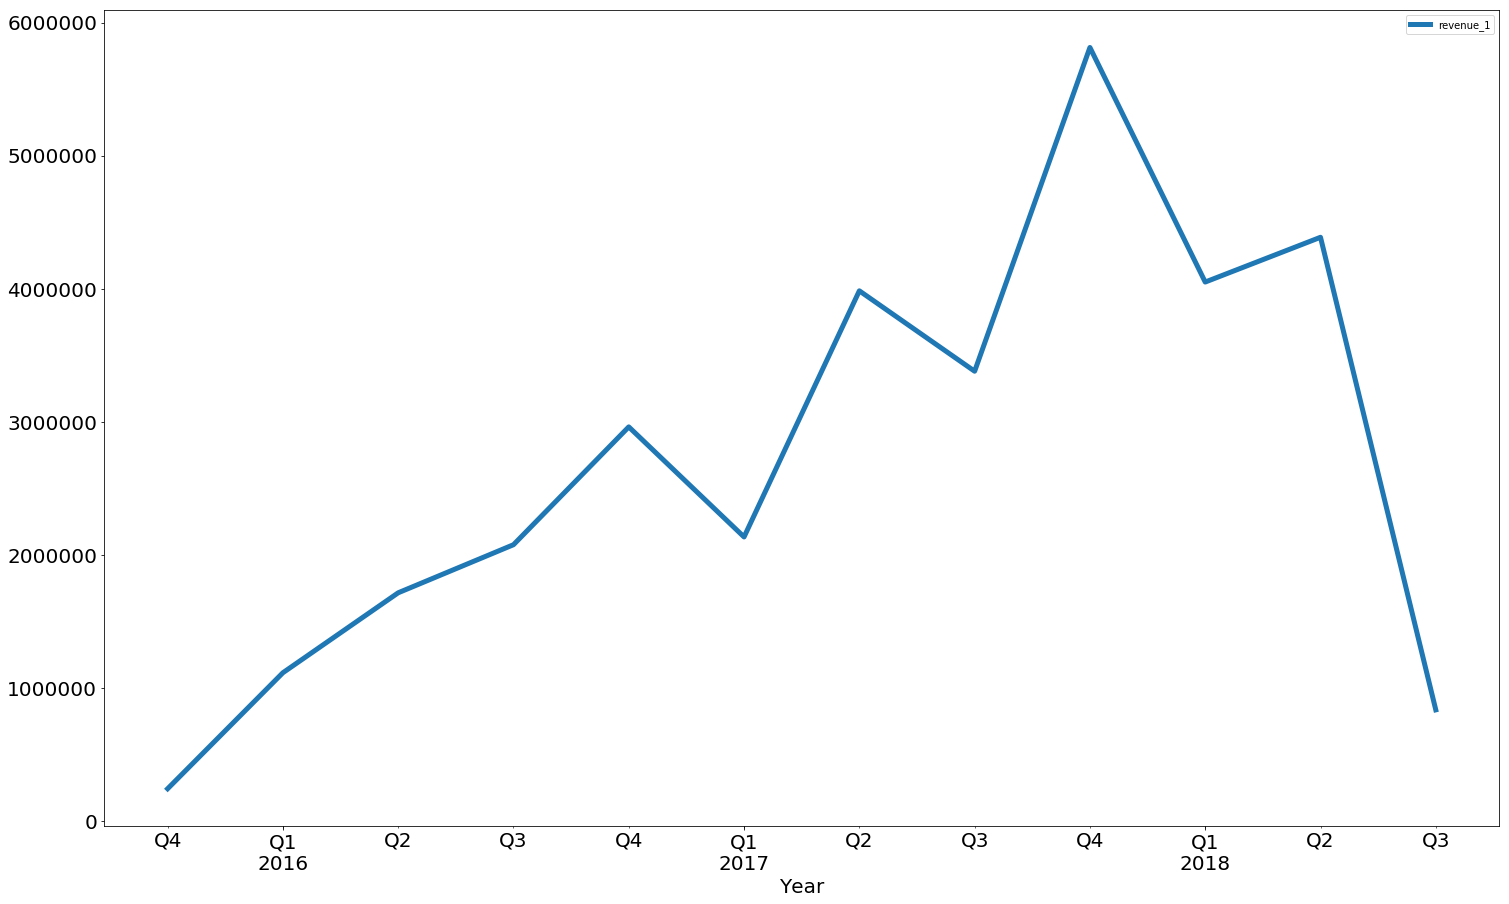

In [17]:
Revenue_Q = tsa_Q_df[['revenue_1']]
tsa_Q_df[['revenue_1']].plot(figsize=(25,15), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

## Compute Quarterly Moving (Rolling) Averages of Sales

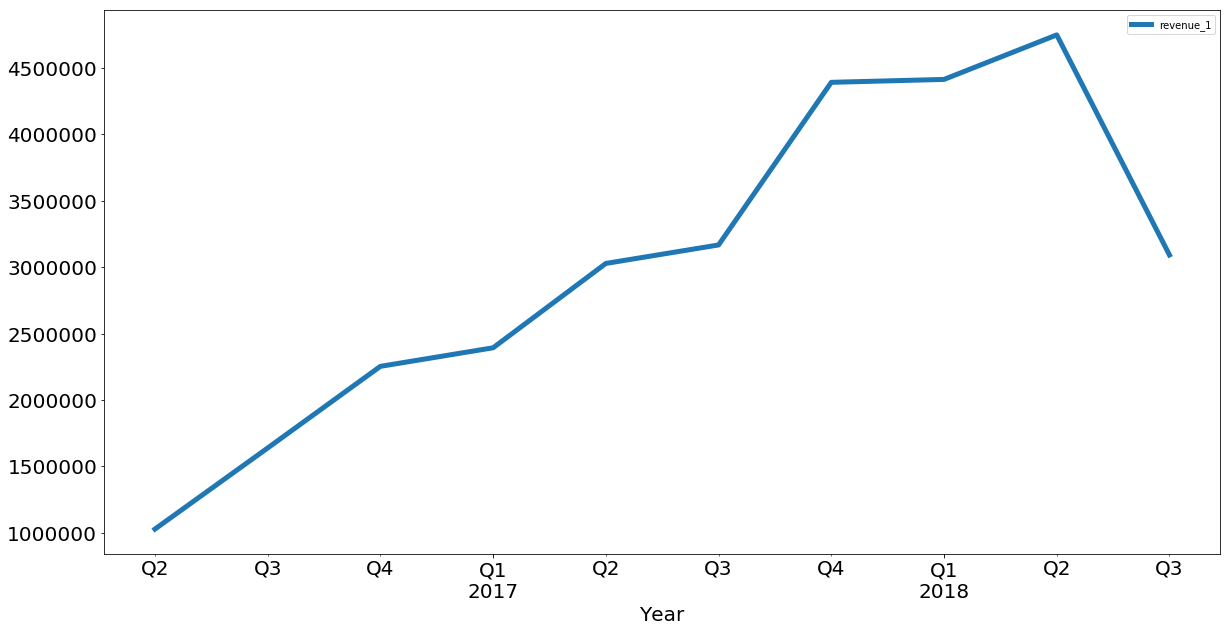

In [18]:
Revenue_Q.rolling(3).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [19]:
# create new dataframe that use month
tsadf_m = df.groupby(['date'])['revenue_1','subtotal','lineitem_quantity','total','discount_amount','refunded_amount'].sum()
tsa_M_df = tsadf_m.resample('M').sum()
tsa_M_df.reset_index(inplace= True)
tsa_M_df['year_month'] = tsa_M_df['date'].apply(lambda x: x.strftime("%m/%d/%y"))
tsa_M_df['year_month'] = pd.to_datetime(tsa_M_df['date'], format='%m/%d/%y')
# tsa_df['year_month'] = pd.to_datetime(tsa_df['date'], format='%m/%d/%y').dt.to_period('M')
tsa_M_df.set_index('year_month', inplace= True)

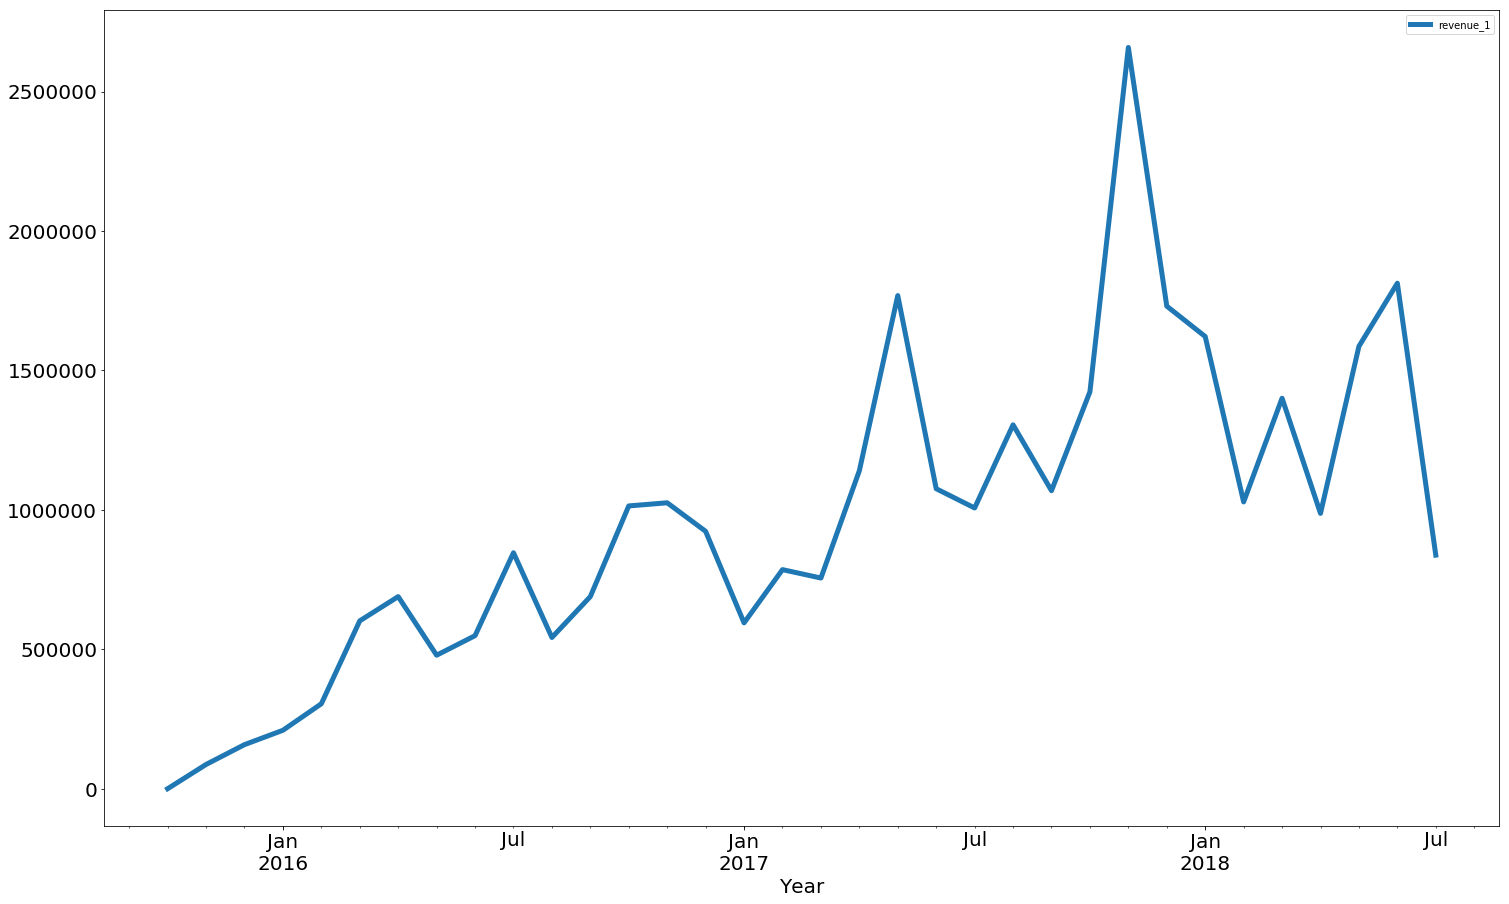

In [20]:
Revenue_M = tsa_M_df[['revenue_1']]
tsa_M_df[['revenue_1']].plot(figsize=(25,15), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

## Compute Monthly Moving (Rolling) Averages of Sales

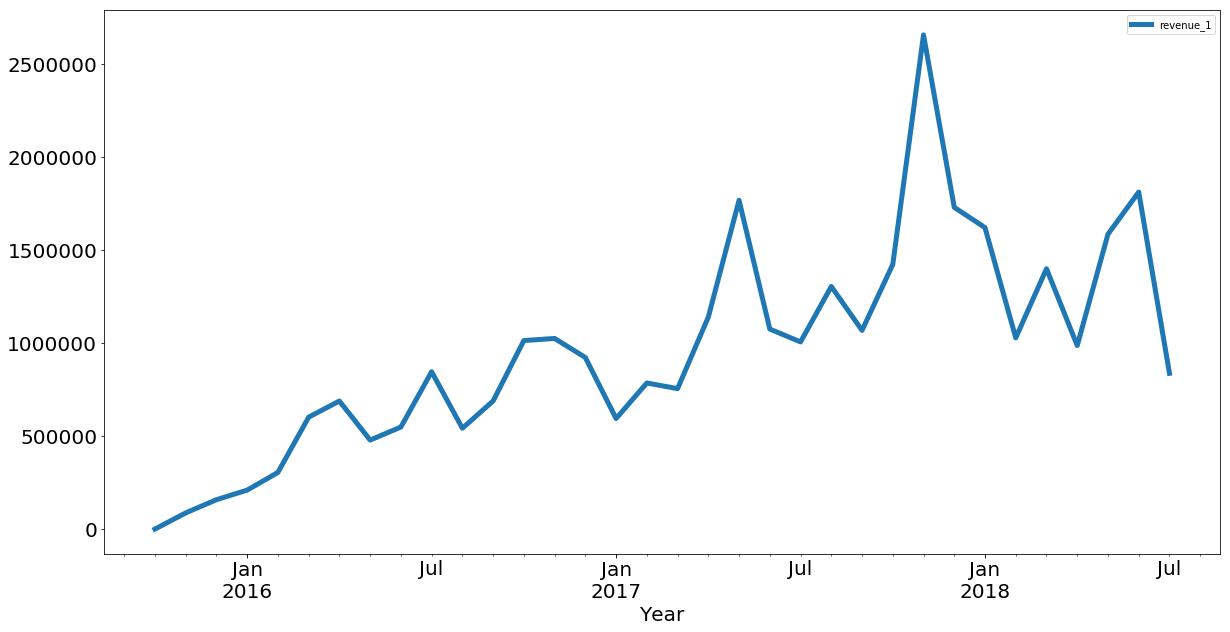

In [35]:
Revenue_M.rolling(1).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

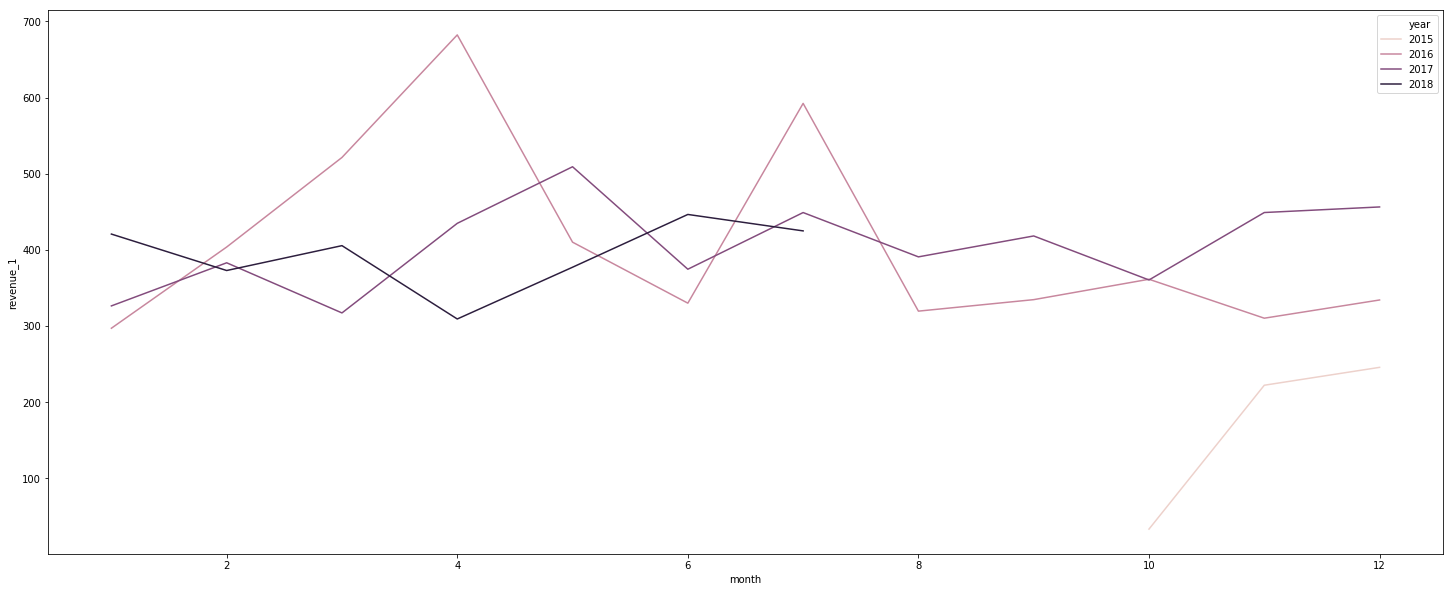

In [45]:
plt.figure(figsize=(25,10))
sns.lineplot(x="month", y="revenue_1", hue="year",ci=None,data=df)

<Figure size 1800x1080 with 0 Axes>

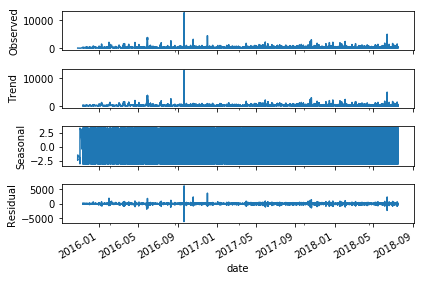

In [34]:
plt.figure(figsize=(25, 15))
# plot observed, trend, seasonal and residual plot 
result = seasonal_decompose(df['revenue'], model='additive', freq = 30)
fig = result.plot()

In [ ]:
plt.figure(figsize=(25,15))
tsa_revenue = df.groupby('date')['revenue'].sum()
tsa_revenue.plot()
pyplot.show()

In [ ]:
tsa_revenue.

In [ ]:
groups = tsa_revenue.groupby(TimeGrouper('A'))
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.plot(subplots = True, legend = False)
pyplot.show()

### Top sales by day of week and year

### Top revenue by day of week

In [ ]:
day_of_weekdf=df.groupby('day_of_week', as_index= False).sum().sort_values(by = 'revenue', ascending = False)

In [ ]:
plt.figure(figsize=(15,10))
sns.pyplot(x="day_of_week", y="revenue",ci=None,data=day_of_weekdf)

#### Hours that converts sales

In [ ]:
df.groupby('time')['subtotal'].sum().plot()

#### Monthly sales from 2015 to 2018

In [ ]:
df.groupby('month')['revenue_1'].sum().plot()

In [ ]:
plt.figure(figsize=(15,10))
sns.lineplot(x="month", y="lineitem_quantity", hue="year",ci=None,data=df)

#### Monthly refund from 2015 to 2018

In [ ]:
df.groupby('month')['refunded_amount'].sum().plot()

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(x="month", y="refunded_amount",hue="year",ci=None,data=df)

### Monthly revenue break down by year

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(x="month", y="revenue",hue="year",ci=None,data=df)

### Monthly revenue from 2015 to 2018

#### Revenu breakdown by time and year

In [ ]:
plt.figure(figsize=(15,10))
sns.lineplot(x="time", y="revenue", hue="year",ci=None,data=df)

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(x="time", y="revenue", hue="month",ci=None,data=df)

### Top line items

In [ ]:
df['lineitem_name'].value_counts().sort_values(ascending = False).head(15)

### Top Sale States

In [ ]:
geodf=df.groupby('shipping_province', as_index= False).sum().sort_values(by = 'subtotal', ascending = False).head(10)

In [ ]:
plt.figure(figsize=(25,15))
sns.barplot(x = 'shipping_province', y = 'revenue', data = geodf)

## Top 20 vendors that generates the most revenue

In [ ]:
df.groupby(['vendor'])['revenue'].agg(sum).sort_values(ascending = False).head(20)

### Most expensive line item

In [ ]:
df.groupby('lineitem_name')['revenue'].sum().sort_values(ascending = False).head(20)

In [ ]:
df.groupby('lineitem_name')['revenue'].sum().sort_values(ascending = False).head(10).plot(kind='bar')

In [ ]:
df.category.value_counts()

In [ ]:
plt.figure(figsize=(15,10))
df.category.value_counts().plot(kind = 'bar')
plt.title('Most popular categories')

In [ ]:
color = ['aqua', 'beige', 'beige-mint', 'beige/black', 'beige/grey', 'beige/pink', 'berry', 'bk-brwon', 'bk-grey', 'bk-ivory',
             'bk-l.brown', 'bk-multi', 'black', 'black-5', 'black-brown', 'black-ivory', 'black-jet', 'black-matte', 'black-pearl',
             'black-red', 'black-silver', 'black-white', 'black/gold', 'black/grey', 'black/silver', 'black/white', 'blue', 'blue-7',
             'blue-ivory', 'blue-topaz', 'blue/yellow', 'brown', 'camouflage', 'champagne', 'cobalt', 'coral', 'coral-pink', 'cream',
             'crystal-gold', 'dark', 'floral', 'fuchsia', 'fuschia', 'gd-blue', 'gd-pink', 'gd-turquoise', 'gold', 'gold-6', 'gold-7',
             'gold-8', 'gold-aqua', 'gold-black', 'gold-blue', 'gold-brown', 'gold-gold', 'gold-gray', 'gold-peach', 'gold-pink',
             'gold-silver', 'gold-two', 'gold-worn', 'gold/black', 'gold/clear', 'gold/silver', 'gold/worn', 'gray', 'green', 'green-topaz',
             'grey', 'grey-2', 'grey/black', 'grey/mint', 'h-pink', 'herringbone', 'holographic', 'ivory', 'ivory-3', 'ivory-beige',
             'ivory-multi', 'ivory/beige', 'ivory/brown', 'ivory/brown-6', 'ivory/grey', 'khaki', 'l-pink', 'lavender', 'lavender/blue',
             'marble', 'metallic', 'mint', 'mint/opal', 'mint/pink', 'multi', 'multi-gold', 'mustard', 'navy', 'navy-red', 'neon', 'nude',
             'olive', 'olive/brown', 'orange', 'orange/pink', 'pastel', 'peach', 'peach-1', 'peach-grey', 'peach/blue', 'pink', 'pink-3',
             'pink-4', 'pink-beige', 'pink/brown', 'pink/burgundy', 'pink/coral', 'pink/mint', 'pink/opal', 'polka', 'purple', 'purple-blue',
             'rainbow', 'red', 'red-pink', 'rose', 'rosey', 'sandy', 'silver', 'silver-6', 'silver-7', 'silver-8', 'silver-brown',
             'silver-clear', 'silver-gold', 'silver-gray', 'silver-jet', 'silver-rustic', 'silver-turquoise', 'silver-worn',
             'sterling\xa0silver', 'teal', 'teal/brown', 'tone-brown', 'tortoise-1', 'turquoise', 'turquoise-blue', 'turquoise-pink',
             'turquoise/blue', 'turquoise/brown', 'turquoise/coral', 'two-tone', 'violet', 'watercolor', 'white', 'white-brown',
             'white-grey', 'white/brown', 'yellow', 'yellow/green']

def word_finder(str, words):
    return ([w for w in str if w in words])

df['color'] = df['lineitem_name'].apply(lambda x: x.lower().split()).apply(lambda x: word_finder(x, color))

new_color_columns = ['color1', 'color2', 'color3', 'color4']
color_df = pd.DataFrame(df['color'].values.tolist(), columns=new_color_columns)
    

In [ ]:
df = pd.concat([df, color_df], axis=1, copy=False)

df.drop('color', axis=1, inplace=True)


In [ ]:
for color_col in new_color_columns:
    df[color_col].fillna('None', inplace=True)
    df[color_col].replace('gray', 'grey', inplace=True)
    df[color_col].replace('grey/black', 'black/grey', inplace=True)
    df[color_col].replace('bk-grey', 'black/grey', inplace=True)
    df[color_col].replace('fuschia', 'fuchsia', inplace=True)

In [ ]:
df.color1.value_counts().sort_values(ascending = False).head(20)

In [ ]:
colordf = df.groupby('color1').sum()['subtotal'].sort_values(ascending = False).head(15)
colordf

In [ ]:
df.groupby('color1').sum()['revenue'].sort_values(ascending = False).head(15).plot(kind = 'bar')

In [ ]:
plt.figure(figsize=(15,10))
colordf[1:].plot(kind = 'bar')
plt.title('Most popular colors')

In [ ]:
headers = df.dtypes.index
headers

In [ ]:
material = ['Onyx', 'Crystal', 'Rhinestone', 'Zirconia', 'Acetate', 'Precious', 'Glass', 'Stone', 'Diamond', 'Lucite', 'Metal', 'Acrylic',
                'Straw', 'Rhodium', 'Filigree', 'Pearl', 'Topaz', 'Leather', 'Fabric', 'Wooden', 'Mirror', 'Aluminium', 'Bamboo',
                'Embroidery', 'Wood', 'Semi-Precious', 'Stones', 'Fur', 'Snake', 'Reptile', 'Studded', 'Cotton', 'Suede', 'Garnet',
                'Geode', 'Woven', 'Amethyst', 'Abalone', 'Sapphire', 'Pebble', 'zirconia', 'Gem', 'Rhineston', 'Silk', 'Amber',
                'Emerald', 'Zircon', 'Aquamarine', 'Linen', 'Ruby', 'Viscose', 'Gold-Rhodium', 'Rhodium/Clear', 'Plastic', 'Steel',
                'Rhodium-Gold', 'Gemstones', 'Velvet', 'Rhodium-Pearl', 'Silicone', 'Rhodium-Sapphire',
                'Hematite-Silver', 'Hematite-Gold', 'Rhodium-Multi', 'Amethyst-Aurore', 'Crystal-Rhodium', 'Gold-Hematite-Brown',
                'Wooden-Fabric']

In [ ]:
df['material'] = df['lineitem_name'].str.extract('({})'.format('|'.join(material)), flags=re.IGNORECASE, expand=False).str.lower().fillna('')



In [ ]:
df['material'].replace('', 'none', inplace=True)

In [ ]:
material_df = df['material'].value_counts().head(15)

In [ ]:
plt.figure(figsize=(15,10))
material_df[1:].plot(kind = 'bar')
plt.title('Most popular materials')

In [ ]:
df_color = df.groupby(['year', 'color1'], as_index = False)['revenue'].sum().sort_values(ascending = False, by = ['revenue']).head(20)
df_color

In [ ]:
df_color= df[(df['color1'] == 'gold')|(df['color1'] == 'silver')|(df['color1'] == 'multi') | (df['color1'] == 'black')|(df['color1'] == 'rose')]

In [ ]:
plt.figure(figsize=(25,10))
sns.barplot(x = 'color1', y = 'revenue',hue = 'year',ci=None, data = df_color)